# The Effectiveness of Qualifier Ratings on the Performance of Loans

## Investigation Overview


In this investigation, I wanted to look at how qualifier ratings, and other qualfiers affected how (i) loans were offered to borrowers and (ii) how well the loans eventually performed. In other words, could the Prosper Ratings,in this data set be a good predictor of **good** or **bad** perfromeing loans. My main focus was on the following attributes of the borrower:
- Prosper Ratinge, 
- The Monthly Income, and
- Monthly Loan Payents


We also focussed on attributes of the loan such as:
- Original Loan Amount, and
- The Borrower APR




## Dataset Overview

The original data consisted of 81 attributes of approximately 113,937 loans. One thousand, three hundred and nine (1,309) data points were removed from the analysis due to inconsistencies or missing information. The data set 2 sets of expressions of the Prosper Rating (numeric and aplphabetic); we opted to utilize the latter as an ordinal variable in our analysis.

With a majority of the variables having numeric, there are however a number of categorical variables, with the `IncomeRange`, `LoanStatus`, `EmploymentStatus` and `ProsperRating (Alpha)` being of interest to our analysis.

(worst) ——> (best) <br>
**IncomeRange**: Not displayed', 'Not employed', 'USD0', 'USD1-24,999','USD25,000-49,999', 'USD50,000-74,999', 'USD75,000-99,999','USD100,000+ <br>
**LoanStatus**: 'Chargedoff', 'Defaulted', 'Past Due',  'Current', 'FinalPaymentInProgress', 'Completed' <br>
**ProsperRating (Alpha)**: 'NC', 'HR', 'E', 'D', 'C', 'B', 'A', 'AA' <br>
**EmploymentStatus**: 'Not available', 'Other', 'Not employed', 'Retired','Self-employed','Employed'

In [17]:
import numpy as np
import pandas as pd
import os
import requests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [18]:
#load data set
df = pd.read_csv('prosperLoanData.csv')
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [19]:
#data wrangling and cleaning steps

#Data Filters for removal
cancelled = df['LoanStatus'] == 'Cancelled'
emp_stat_nan = df['EmploymentStatus'].isnull()
employed = (df['EmploymentStatus'] == 'Full-time') | (df['EmploymentStatus'] == 'Part-time')
zeros_income_r = df['IncomeRange'] == '$0'
noemp_income_r = df['IncomeRange'] == 'Not employed'
high_income = df['StatedMonthlyIncome'] >= 100000
high_inc_ratio = (df['DebtToIncomeRatio'] >= 9.5 )
not_employed = (df['EmploymentStatus'] == 'Not employed')
final_payment = df['LoanStatus'] == 'FinalPaymentInProgress'
#
df_clean = df.copy()

In [20]:
#Replace values that match 'Past Due' as a substring with 'Past Due'
df_clean.loc[df_clean['LoanStatus'].str.contains('Past'), 'LoanStatus'] = 'Past Due'

#Replace values that match NaN with string 'Not avaiable'
df_clean.loc[df_clean['EmploymentStatus'].isnull(), 'EmploymentStatus'] = 'Not available'

#For each row, copy values in CreditGrade column (pre 2009) into the null spaces in 'ProsperRating (Alpha)'
df_clean.loc[df_clean['ProsperRating (Alpha)'].isnull(), 'ProsperRating (Alpha)'] = df_clean.CreditGrade

#convert to datetime data types
df_clean.ListingCreationDate = pd.to_datetime(df_clean.ListingCreationDate)
df_clean.ClosedDate = pd.to_datetime(df_clean.ClosedDate)
df_clean.DateCreditPulled = pd.to_datetime(df_clean.DateCreditPulled)
df_clean.LoanOriginationDate = pd.to_datetime(df_clean.LoanOriginationDate)

#Replace values that match NaN with string 'Not avaiable'
df_clean.loc[employed, 'EmploymentStatus'] = 'Employed'

#For each row, copy values 'NC' into the null spaces in 'PropsperRating (Alpha)'
df_clean.loc[df_clean['ProsperRating (Alpha)'].isnull(), 'ProsperRating (Alpha)'] = 'NC'

#Remove entries considered high income (over $100,000)
df_clean = df_clean.loc[-high_income,:]

#Remove entires with income-ratio greater than 9
df_clean = df_clean.loc[-high_inc_ratio,:]

#Remove cancelled loan entries
df_clean = df_clean.loc[-cancelled,:]

#Remove Not employed status entries
df_clean = df_clean.loc[-not_employed,:]

#Remove final  payment loan entries
df_clean = df_clean.loc[-final_payment,:]

In [21]:
# convert IncomeRange, LoanOriginationQuarter, LoanStatus, ProsperRating (Alpha) and Employment Status into ordered categorical types
ordinal_var_dict = {'IncomeRange': ['Not displayed', 'Not employed', '$0', '$1-24,999','$25,000-49,999', 
                                    '$50,000-74,999', '$75,000-99,999','$100,000+'], 
                    'LoanStatus': ['Chargedoff', 'Defaulted', 'Past Due',  'Current', 'Completed'],
                    'ProsperRating (Alpha)': ['NC', 'HR', 'E', 'D', 'C', 'B', 'A', 'AA'],
                    'EmploymentStatus':['Not available', 'Other', 'Retired','Self-employed','Employed']
                    }

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    df_clean[var] = df_clean[var].astype(ordered_var)

In [22]:
df_clean.reset_index(drop=True, inplace = True)
print(df_clean.shape)

(112628, 81)


## Distribution of Loans

Loans in the dataset take on a very large range of values, from about USD1000 at the lowest, to USD35,000 at the highest. The distribution of loan amounts took on a multimodal shape with several peaks at \\$1000, \\$4000, \\$10,000, \\$15,000, \\$20,000 and \\$25,000 that suggested popular loan packages.

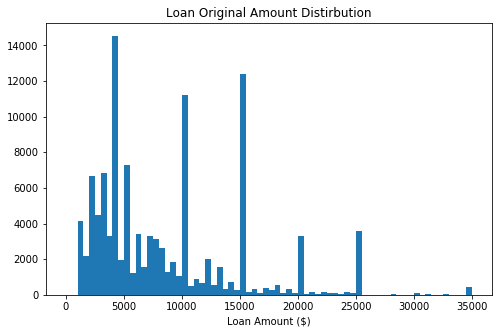

In [23]:
# Explore loan distribution by creating a standard plot of the Loan Original Amount (Quantitative Univariate)
binsize = 500
bins = np.arange(0, df_clean['LoanOriginalAmount'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.title('Loan Original Amount Distirbution')
plt.hist(data = df_clean, x = 'LoanOriginalAmount', bins = bins)
plt.xlabel('Loan Amount ($)')
plt.show()

## Distribution of Loan Performance

Performance of loans in the dataset were mostly in the 'Current Category', with 'Completed' loans having the second highest perfromance. Most loans in negative categories ('Past Due, Defaulted and Chargedoff') were a smaller percentage of the dataset withthe 'Chargedoff' category having the highest number of negative performing loans at 11,891.

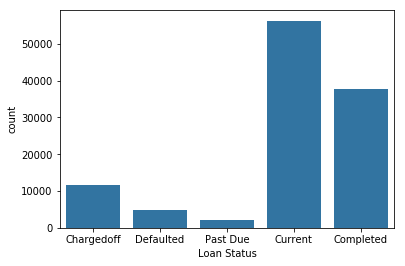

In [24]:
# Create bar chart of Loan Status information (Qualitative Univariate)
base_color = sb.color_palette()[0]
sb.countplot(data = df_clean, x = 'LoanStatus', color = base_color)
plt.xlabel('Loan Status')
plt.show()

## Distribution of Prosper Ratings
Using the ProsperRating (Alpha) variable in the dataset, we find a normal distribution with the peak at 'C' rating, which is considered an average weighted rating score.

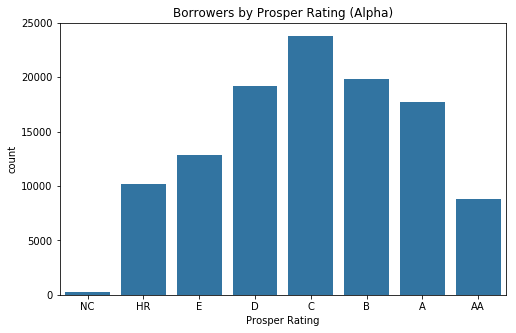

In [25]:
# Create bar chart of Propser Rating (Qualitative Univariate)
base_color = sb.color_palette()[0]
plt.figure(figsize=[8, 5])
sb.countplot(data = df_clean, x = 'ProsperRating (Alpha)', color = base_color)
plt.xlabel('Prosper Rating')
plt.title('Borrowers by Prosper Rating (Alpha)')
plt.show()

## ProsperRating vs. Loan Status

Plotting a clustered bar chart of these key qualitative variables (Prosper Rating vs. Loan Status) provides an initial insight into how well loans perfrom based on their ratings. We can deduce that borrowers assigned lower Propser Ratings (NC, HR, E & D) have a higher proportion of their loans performing negatively (Chargedoff, Defaulted & Past Due) than those performing positively (Current & Completed).


Interestingly, borrowers assigned the propser rating 'C' proportionally have more good performing loans (Current & Completed)than all other Propser ratings, with a majority of the loans in the 'Current' status.

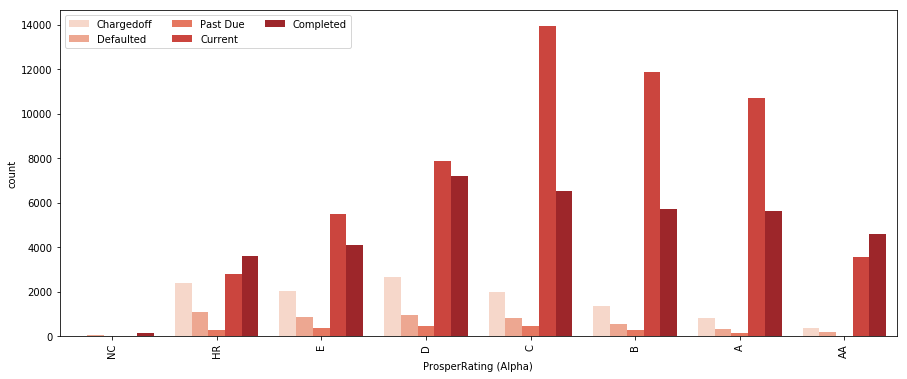

In [26]:
plt.figure(figsize = [15, 6])
sb.countplot(data = df_clean, x = 'ProsperRating (Alpha)', hue = 'LoanStatus', palette = 'Reds')
plt.xticks(rotation =90)
plt.legend(loc = 2, ncol = 3); # re-arrange legend to reduce overlapping

## Interactions between Prosper Rating and Loan Status to Borrower's Monthly Income
From the plots, below, we can see a clear interaction between the Propser Rating  and the Monthly Income of the borrower. As the monthly income of the borrower increases, the Prosper Rating assigned to the borrower increases. 

Similarly, in the case of the status of the loan, there is a noticable trend in the relationship between Monthly Income and the Loan Status variables, whereby an increase in monthly income results in an improvement in the status of the loan. We do however concede that there is a slight dip in the median monthly income values of loans with a 'Complete' category designation but may not be considered significant.

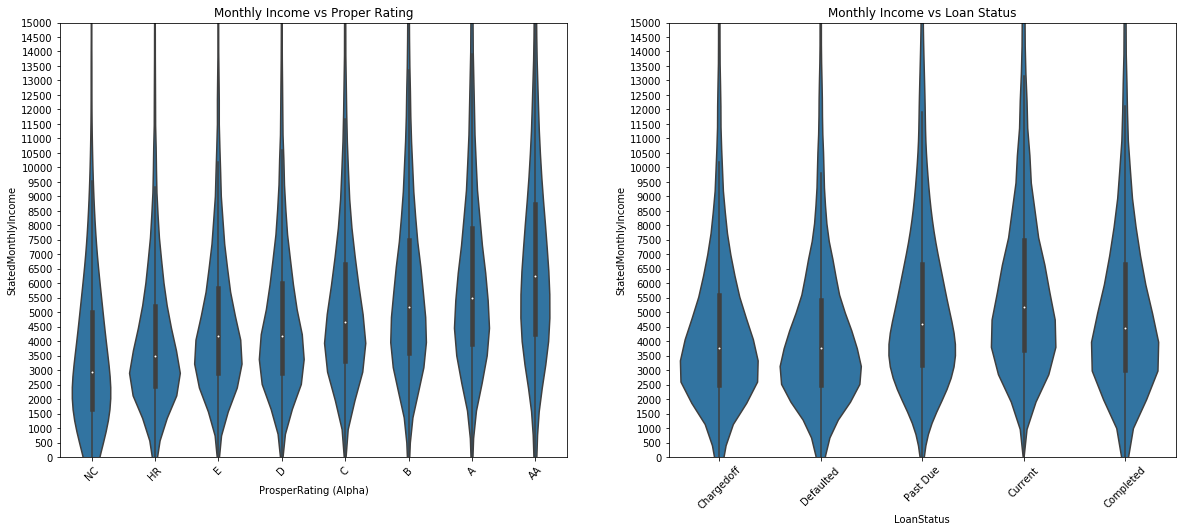

In [27]:
base_color = sb.color_palette()[0]
plt.subplots(1,2, figsize = [20,8])

plt.subplot(1,2,1)
yticks = np.arange(0, 15000+50, 500)
sb.violinplot(data = df_clean, x = 'ProsperRating (Alpha)', y = 'StatedMonthlyIncome', color = base_color);
plt.ylim([-10,15000])
plt.yticks(yticks, yticks)
plt.xticks(rotation = 45);
plt.title('Monthly Income vs Proper Rating');

plt.subplot(1,2,2)
yticks = np.arange(0, 15000+50, 500)
sb.violinplot(data = df_clean, x = 'LoanStatus', y = 'StatedMonthlyIncome', color = base_color);
plt.ylim([-10,15000])
plt.yticks(yticks, yticks)
plt.xticks(rotation = 45);
plt.title('Monthly Income vs Loan Status');



## Other Interesting Interactions
For other plots generated, we see clear interactions between the Prosper Rating with Loan Amount offered to the borrower. The higher the loan amount, the better the Prosper Rating assigned to the borrower. The plot also suggests that fewer loans are offered at the higher amounts, which suggests the products are often targeted at borrowers that do not typically be assigned a better Prosper Rating

Propser Rating interactions with the Loan APR offered to the borrower is also evident, whereby loan interest rates are observed to be decreasing as the Prosper Rating assigned to the borrower improves.

**Note**: A similar investigation of the interactions between Loan Status with the Loan Amount and Borrower APR were performed respectively. The results, however, did not show a clear interaction which suggested that other factors may need to be considered. 


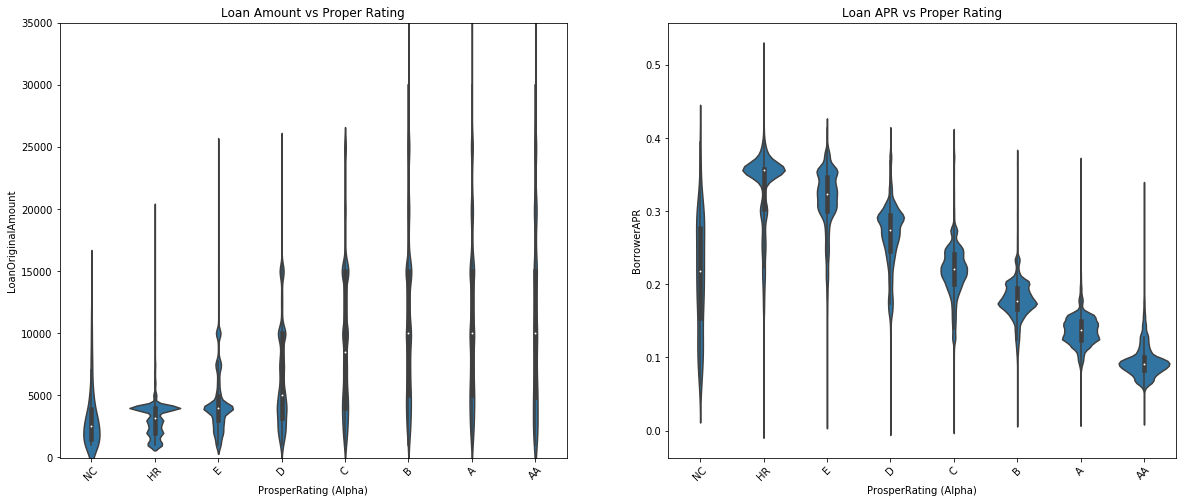

In [28]:
base_color = sb.color_palette()[0]
plt.subplots(1,2, figsize = [20,8])

plt.subplot(1,2,1)
yticks = np.arange(0, df_clean['LoanOriginalAmount'].max()+50, 5000)
sb.violinplot(data = df_clean, x = 'ProsperRating (Alpha)', y = 'LoanOriginalAmount', color = base_color);
plt.ylim([-10,15000])
plt.yticks(yticks, yticks)
plt.xticks(rotation = 45);
plt.title('Loan Amount vs Proper Rating');


plt.subplot(1,2,2)
sb.violinplot(data = df_clean, x = 'ProsperRating (Alpha)', y = 'BorrowerAPR', color = base_color);
plt.xticks(rotation = 45);
plt.title('Loan APR vs Proper Rating');

## Loan Amounts by Loan Status and Prosper Rating

I observed how the loan amount affects or is affected by the Prosper Rating and Loan Status by plotting the average loan amounts against the entire dataset as well as a subset (Income Range: $25,000 -49,999). The results showed a consistent rise in the loan amount as the Prosper Rating of the borrower increases. 

Within each Prosper Rating level, however, we do not see a clear trend across the loan status grades (Chargedoff is lowest, Completed is highest).

It is significant to mention that I found that borrowers with better Prosper Ratings (A & AA) seem to have worse loan performances at higher loan amounts, whereas this observation was not consistent in other lower Prosper Rating categories. 

In [29]:
#create subset of Income Range $25k-$50k
inc_25k_50k = df_clean[df_clean['IncomeRange'] == '$25,000-49,999']
inc_25k_50k.shape

(32138, 81)

[]

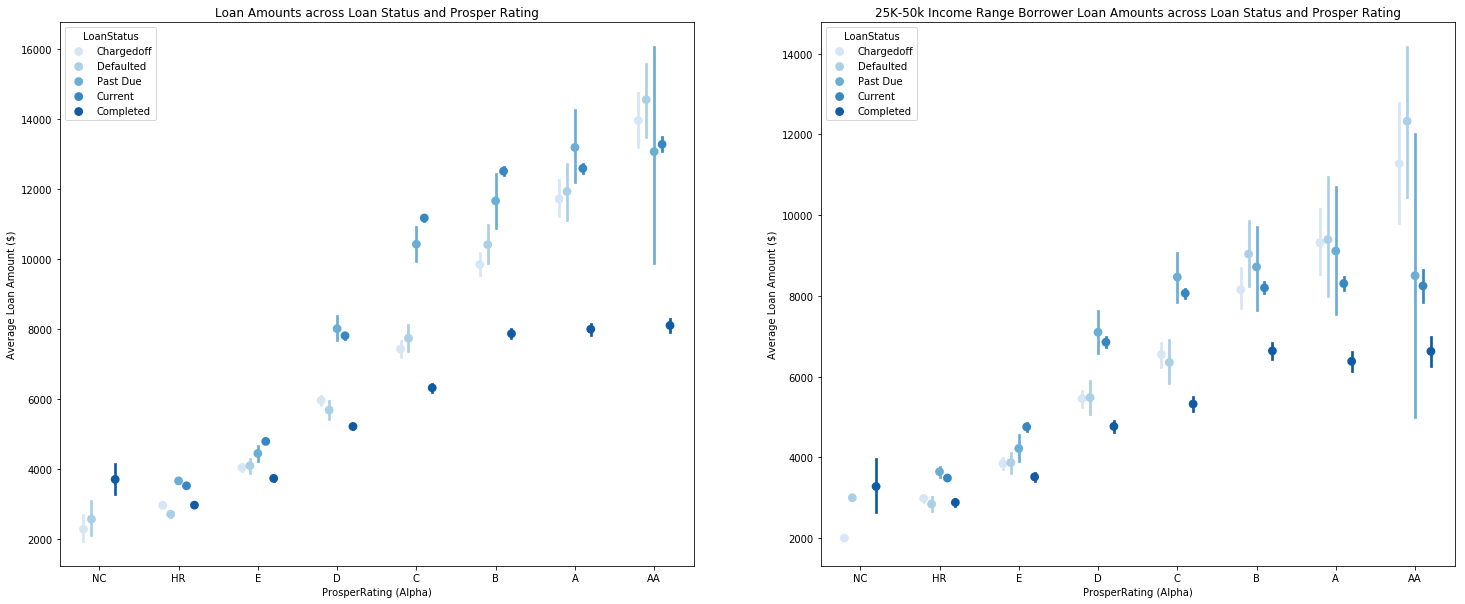

In [30]:
#create pointplots of Loan Amount across Loan Status and Prospoer Rating
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = [25,10])

sb.pointplot(data = df_clean, x = 'ProsperRating (Alpha)', y = 'LoanOriginalAmount', hue = 'LoanStatus', 
                  palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[0])
ax[0].set_title('Loan Amounts across Loan Status and Prosper Rating')
ax[0].set_ylabel('Average Loan Amount ($)')
ax[0].set_yticks([2e3, 4e3, 6e3, 1e4], ['2k', '4k', '6k', '10k'])
ax[0].set_yticklabels([],minor = True)

sb.pointplot(data = inc_25k_50k, x = 'ProsperRating (Alpha)', y = 'LoanOriginalAmount', hue = 'LoanStatus', 
                  palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[1])
ax[1].set_title('25K-50k Income Range Borrower Loan Amounts across Loan Status and Prosper Rating')
ax[1].set_ylabel('Average Loan Amount ($)')
ax[1].set_yticks([2e3, 4e3, 6e3, 1e4], ['2k', '4k', '6k', '10k'])
ax[1].set_yticklabels([],minor = True)

## Interest APR by Loan Status and Prosper Rating

I also observed how the borrower's interst rate (APR) affects or is affected by the Prosper Rating and Loan Status by plotting the average APRs against the entire dataset as well as a subset (Income Range: $25,000 -49,999). The results again how a consistent fall in the average APR as the Prosper Rating of the borrower improves. 

Within each Prosper Rating level however, we also see a clear trend that may suggest that borrowers, particularly those with positive loan performances (Completed & Current) tend to do so at the lowest levels of interest rates made available to them irrespective of the loan size.


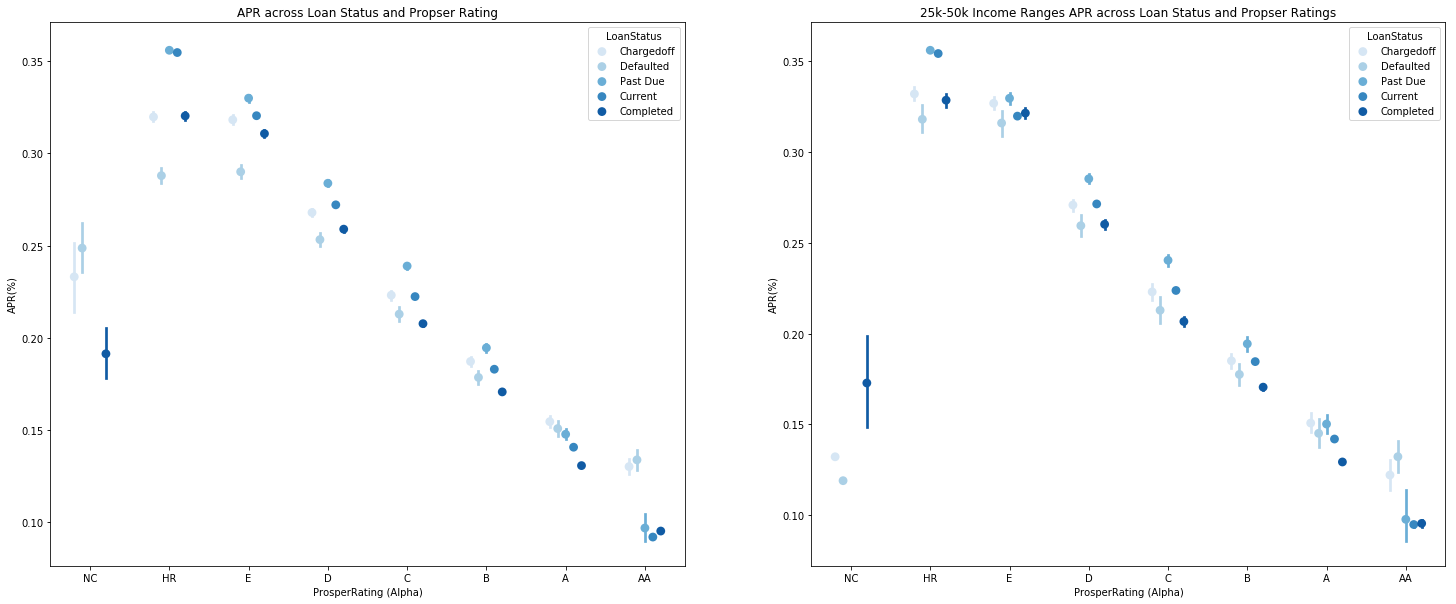

In [31]:
#create pointplots of Borrower APR across Loan Status and Prosper Rating
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = [25,10])

sb.pointplot(data = df_clean, x = 'ProsperRating (Alpha)', y = 'BorrowerAPR', hue = 'LoanStatus', 
                  palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[0])
ax[0].set_title('APR across Loan Status and Propser Rating')
ax[0].set_ylabel('APR(%)')
ax[0].set_yticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35], ['10', '15', '20', '25', '30', '35'])
ax[0].set_yticklabels([],minor = True)

sb.pointplot(data = inc_25k_50k, x = 'ProsperRating (Alpha)', y = 'BorrowerAPR', hue = 'LoanStatus', 
                  palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[1])
ax[1].set_title('25k-50k Income Ranges APR across Loan Status and Propser Ratings')
ax[1].set_ylabel('APR(%)')
ax[1].set_yticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35], ['10', '15', '20', '25', '30', '35'])
ax[1].set_yticklabels([],minor = True)
plt.show();


## Summary of Findings
The appears to be multiple variables and/or conditions that may affect the performance of a loan. It is however clear that the Prosper Rating score of a borrower does influence and can be a good predictor of how well a loan performs. This has been concluded based on the findings below:

- The Prosper Ratings assigned to a borrower tends to improve with an increase in the borrower's monthly income
- The Loan APR offered to a borrower tends to decrease with improvements in the borrower's Prosper Rating
- The Loan Amount offered to a borrower also tends to increase with improvements in the borrower's Prosper Rating
- Borrowers with better Prosper Ratings tend to have their loan perform poorly at the upper limits of the loan amounts compared to borrowers with below average Prosper Ratings


## Thank you
Report prepared by Babatomiwa (Tomi) Adegbenro


Udacity - Data Analysis Nanodegree


May 2019